In [1]:
from pprint import pprint
import sys
import numpy as np
import configobj

import emcee

from model import Eclipse, Band, LCModel, Lightcurve, GPEclipse
from mcmc_utils import Param
import mcmc_utils as utils

%matplotlib inline

In [2]:
input_file = 'mcmc_input.dat'

input_dict = configobj.ConfigObj(input_file)

# Read in information about mcmc, neclipses, use of complex/GP etc.
nburn = int(input_dict['nburn'])
nprod = int(input_dict['nprod'])
nthreads = int(input_dict['nthread'])
nwalkers = int(input_dict['nwalkers'])
ntemps = int(input_dict['ntemps'])
scatter_1 = float(input_dict['first_scatter'])
scatter_2 = float(input_dict['second_scatter'])
to_fit = int(input_dict['fit'])
is_complex = bool(int(input_dict['complex']))
use_gp = bool(int(input_dict['useGP']))
use_pt = bool(int(input_dict['usePT']))
corner = bool(int(input_dict['corner']))
double_burnin = bool(int(input_dict['double_burnin']))
comp_scat = bool(int(input_dict['comp_scat']))

# neclipses no longer strictly necessary, but can be used to limit the
# maximum number of fitted eclipses
try:
    neclipses = int(input_dict['neclipses'])
except KeyError:
    neclipses = -1

if use_gp:
    # TODO: Impliment the GP version of the Eclipses.
    # Read in GP params using fromString function from mcmc_utils.py
    ampin_gp = Param.fromString('ampin_gp', input_dict['ampin_gp'])
    ampout_gp = Param.fromString('ampout_gp', input_dict['ampout_gp'])
    tau_gp = Param.fromString('tau_gp', input_dict['tau_gp'])


In [3]:
# Start by creating the overall Model. Gather the parameters:
core_par_names = ['rwd', 'dphi', 'q']

core_pars = [Param.fromString(name, s) for name, s in input_dict.items()
             if name in core_par_names]

# and make the model object with no children
model = LCModel('core', core_pars)

In [4]:
# Collect the bands and their params. Add them total model.
band_par_names = ['wdFlux', 'rsFlux']

# Get a sub-dict of only band parameters
band_dict = {}
for key, string in input_dict.items():
    if np.any([key.startswith(par) for par in band_par_names]):
        band_dict[key] = string

# Get a set of the bands we have in the input file
defined_bands = [key.split('_')[-1] for key in band_dict]
defined_bands = set(defined_bands)
print("I found definitions of the following bands: {}".format(
    defined_bands))

for band in defined_bands:
    band_pars = []
    for key, string in band_dict.items():
        if key.endswith("_{}".format(band)):
            name = key.split("_")[0]
            band_pars.append(Param.fromString(name, string))

    band = Band(band, band_pars, parent=model)


I found definitions of the following bands: {'KG5', 'g', 'r'}


In [5]:
class TimeEclipse(Eclipse):
    def calc(self, plot=False):
        '''This version of the Eclipse does not actually call lfit's calcflux, 
        rather just passes through. I want to isolate time savings that 
        don't involve that part of the code/.'''
        
        # Fetch the cv parameter vector, to see if it takes a while or not.
        cvPars = self.cv_parlist
        
        if plot:
            self.lc.plot(self.cv.calcFlux(
                self.cv_parlist, self.lc.x, self.lc.w
            ))
        
        # Just return a random value
        return 100.0
        

In [6]:
# These are the entries to ignore.
descriptors = ['file', 'plot', 'band']
descriptors += band_par_names
descriptors += core_par_names
complex_desc = ['exp1', 'exp2', 'yaw', 'tilt']
if not is_complex:
    print("Using the complex BS model. ")
    descriptors.extend(complex_desc)

ecl_i = -1
while True:
    ecl_i += 1

    # The user can limit the number if eclipses to fit.
    if ecl_i == neclipses:
        break

    # Collect this eclipses' parameters.
    ecl_exists = [key.endswith("_{}".format(ecl_i)) for key in input_dict]
    if np.any(ecl_exists):
        # Initialise this eclipses's stuff.
        eclipse_pars = []

        # What band are we going to be looking at?
        band = input_dict['band_{}'.format(ecl_i)]
        # Retrieve the band object, so we can request it as a parent later
        band = model.search_Node('Band', band)

        # print("Eclipse {} belongs to the {}".format(ecl_i, band.name))

        # Loop through the input dict, searching for keys that have a tail
        # matching this eclipse
        for key, string in input_dict.items():
            if key.endswith("_{}".format(ecl_i)):

                # Make sure we don't create a parameter from any of the
                # descriptors. Check none of the forbidden keys are in this
                test = [d in key for d in descriptors]
                if np.any(test):
                    continue

                # Construct the name of the parameter,
                # i.e. strip off the tail code
                name = key.replace("_{}".format(ecl_i), '')

                # print("{} has the parameter {}, calling it {}".format(
                #     ecl_i, key, name))

                # Make the Param object from the string, and add it to
                # our list of pars.
                param = Param.fromString(name, string)
                eclipse_pars.append(param)

        # Read in the datafile associated with this eclipse
        fname = input_dict['file_{}'.format(ecl_i)]
        eclipse_data = Lightcurve.from_calib(fname)

        # Trim the eclipse down to our desired range.
        start = float(input_dict['phi_start'])
        end = float(input_dict['phi_end'])
        eclipse_data.trim(start, end)

        ampin = Param.fromString('ampin_gp', input_dict['ampin_gp'])
        ampout = Param.fromString('ampout_gp', input_dict['ampout_gp'])
        tau = Param.fromString('tau_gp', input_dict['tau_gp'])
        
        # Construct the eclipse object
        GPEclipse(ampin, ampout, tau, eclipse_data, is_complex, str(ecl_i), eclipse_pars,
                parent=band)

        # print("\n\n")
    else:
        break


Fitting 10 eclipses.
Figure will be (28.0, 5.0)


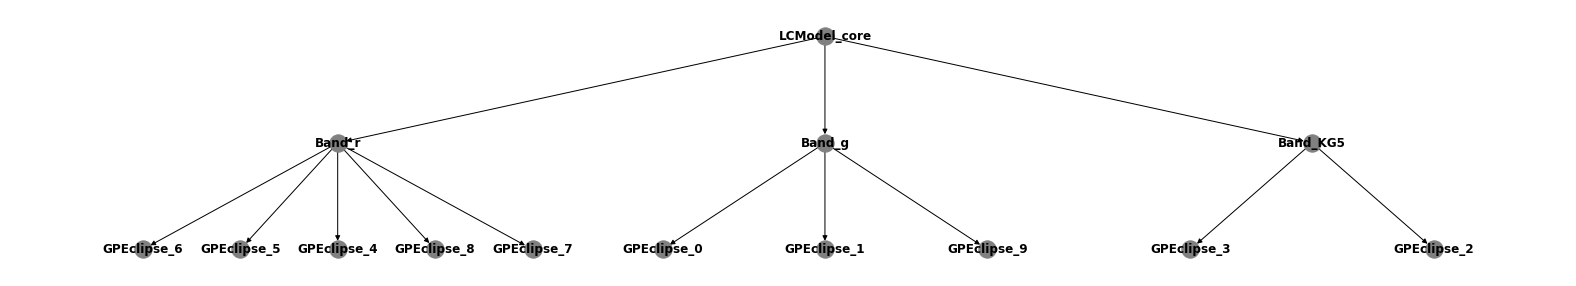

In [7]:
neclipses = ecl_i
print("Fitting {} eclipses.".format(neclipses))
model.draw()

In [8]:
print(model.chisq())
%timeit model.chisq(False)

8210.35858448112
544 ms ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
